# A room with a view - Using support vectors to predict room occupancy #

Notebook prepared by Evert van Doorn, e.a.vandoorn@gmail.com. Feel free to send me your opinion!

Data taken from the UCI machine learning repository at https://archive.ics.uci.edu, specifically https://archive.ics.uci.edu/ml/machine-learning-databases/00357/. The data was uploaded by Luis Candanedo, luismiguel.candanedoibarra@umons.ac.be, UMONS in Belgium.

Sometimes, you want to know if a room is occupied. Perhaps you run a hotel and want to know how much time your staff spend cleaning, you could manage a school and want to quantify how efficiently space is used, or you want to see how many of your employees are (not) in the office on a given weekday. You could find out by counting, but why not let  python and some sensors do the work for you?

In this notebook, we will use a support vector machine to model room occupancy based on sensor data. We'll prepare the data for modeling, compare three ways of handling an imbalance in the categories of our target variable, and find the optimal support vector classifier for this problem. In the mean time, we will also consider the utility of this model for modeling room occupancy continuously.

### Data specification and model choice

The data set contains a date and time of measurement, along with: 
* the temperature in the room expressed in degrees Celcius; 
* the humidity in the room expressed in percentage points;
* the level of light in the room expressed in lux;
* the level of CO2 in the air in the room, expressed in parts per million;
* the humidity ratio (derived from temperature and humidity) expressed in kg of water vapor / kg of air.
* whether the room was occupied (value 1) or not (value 0)

In this notebook, we will use a Support Vector Classifier, as it is a simple but powerful model that was not used in the original publication on these data by Candanedo & Feldheim (2016). ts biggest competitor, and probably a better choice for this data in the abstract, is a decision tree model, which was tested by these authors. The support vector classifier has a different approach to data, which makes it worth trying out. 

Rather than finding a distribution of probabilities within the data, a support vector classifier uses the features to find the best geometrical separation of our two groups of interest (i.e. occupied vs. non-occupied) in a high-dimensional space. By using the data points, we can more easily visualize the effects of parameter changes and feature engineering on misclassified data points (by plotting a decision boundary), should that prove necessary when we take the model into production. 


In [55]:
# To start, let's import some useful stuff

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import sklearn
from seaborn import heatmap
from statsmodels.api import qqplot
from scipy.stats import multivariate_normal

from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, validation_curve, learning_curve
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# and set some settings for the matplotlib library.

%matplotlib inline
mpl.style.use('ggplot')
plt.rcParams["figure.figsize"] = (20, 6)

In [56]:
# Next, let's define some functions for later use (mostly for plotting purposes)

def correlation_heatmap(df):
    """Plot correaltions of a dataframe of columns with numeric datatypes in a heatmap plot"""
    colormap = plt.cm.viridis
    plt.figure(figsize=(12,12))
    plt.title('Pearson Correlation of Features ', y=1.05, size=15)
    heatmap(df.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)
    plt.show()
    plt.clf()

def numvar_parallel_coordinates(df, categoricalCol):
    """Plot a parallel coordinates map of a dataframe of columns with numeric datatypes"""
    from pandas.tools.plotting import parallel_coordinates
    colormap = plt.cm.viridis
    plt.figure(figsize=(12,12))
    plt.title('Parallel Coordinates of Feature Space ', y=1.05, size=15)
    parallel_coordinates(df, categoricalCol)    
    plt.plot()
    plt.clf()
    
def numvar_andrews_curves(df, categoricalCol):
    """Plot an andrews curves graph of a dataframe of columns with numeric datatypes"""
    from pandas.plotting import andrews_curves
    colormap = plt.cm.viridis
    plt.figure(figsize=(12,12))
    plt.title('Andrews Curves for Feature Space ', y=1.05, size=15)
    andrews_curves(df, categoricalCol)    
    plt.show()
    plt.clf()
    
def numvar_hist(df, targetCol):
    """Plot histogram by feature in relation to both levels of target"""
    colormap = plt.cm.viridis
    for col in df.columns:
        if col == 'Occupancy':
            pass
        else:
            bins = np.linspace((df[col].min()*.9), (df[col].max()*1.1), 100)
            for val in df['Occupancy'].unique():
                plt.hist(df.loc[(df['Occupancy'] == val), col], bins, alpha=0.5, label=col)
            plt.legend(loc='upper right')
            plt.title(('Histogram ' + str(col)), y=1.05, size=15)
            plt.show()
            plt.clf()
             
            
def scale_features_df(df):
    """Autoscale features to have a mean of 0 (center around mean)"""
    scaled = sklearn.preprocessing.StandardScaler().fit_transform(df)
    scaled = pd.DataFrame(scaled, columns=df.columns)
    return scaled

def draw_vectors(transformed_features, components_, columns, plt):
    num_columns = len(columns)
    """Projects an *original* feature (columns) onto the 
    principal component feature-space, visualizing how "important" 
    each one was in the multi-dimensional scaling. Taken from Authman 
    Aphira's python course."""

    xvector = components_[0] * max(transformed_features[:,0])
    yvector = components_[1] * max(transformed_features[:,1])

    important_features = { columns[i] : math.sqrt(xvector[i]**2 + yvector[i]**2) for i in range(num_columns) }
    important_features = sorted(zip(important_features.values(), important_features.keys()), reverse=True)
    print("Features by importance:\n", important_features)

    ax = plt.axes()

    for i in range(num_columns):
        plt.arrow(0, 0, xvector[i], yvector[i], color='black', width=0.0005, head_width=0.02, alpha=1)
        plt.text(xvector[i]*1.2, yvector[i]*1.2, list(columns)[i], color='black', alpha=1)

    return ax

def decision_function_2f(clf, X, y):
    """Takes classifier, X, and y, and plots the decision function for each datapoint on the grid. Taken from the sklearn documentation."""
    X = X.values[:, :2]     
    h = .02 

    clf.fit(X, y)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    title = 'SVC decision boundary for two principal components'

    plt.figure(figsize=(12,12))
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.viridis, alpha=0.8) #was coolwarm

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.viridis)
    plt.xlabel('component 1')
    plt.ylabel('component 2')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(title)

    plt.show()
    plt.clf()
    
        
def plot_validation_curve(classifier, X, y):
    """Takes a classifier and X and y data, and returns plots for classifier scores at various values of C and gamma. 
    Taken from the python sklearn documentation."""
    params = {'C': list(np.logspace(-6, 6, 5)), 'gamma':list(np.logspace(-6, 6, 5))}
    for param in params:
        train_scores, test_scores = validation_curve(
            classifier, X, y, param_name=param, param_range=params[param],
            cv=5, scoring="accuracy", n_jobs=1)
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        plt.title("Validation Curve with SVM")
        plt.xlabel(param)
        plt.ylabel("Score")
        plt.ylim(0.0, 1.1)
        lw = 2
        plt.semilogx(params[param], train_scores_mean, label="Training score",
            color="darkorange", lw=lw)
        plt.fill_between(params[param], train_scores_mean - train_scores_std,
            train_scores_mean + train_scores_std, alpha=0.2,
            color="darkorange", lw=lw)
        plt.semilogx(params[param], test_scores_mean, label="Cross-validation score",
            color="navy", lw=lw)
        plt.fill_between(params[param], test_scores_mean - test_scores_std,
            test_scores_mean + test_scores_std, alpha=0.2,
            color="navy", lw=lw)
        plt.legend(loc="best")
        plt.show()
        plt.clf()
        return

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.
    
    Function taken from the sklearn documentation

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()
    plt.clf()
    return

In [57]:
# Originally, the data set consists of three collections of measurements: training, testing and validation sets.
# We want to use cross-validation, so let's concatenate all data sets into one. 

file1 = pd.read_csv('datatest.txt', header = 0, sep = ',')
file2 = pd.read_csv('datatest2.txt', header = 0, sep = ',')
file3 = pd.read_csv('datatraining.txt', header = 0, sep = ',')
df = pd.concat([file1, file2, file3], axis = 0)
print(df.head(5))
print(df.shape)

                    date  Temperature  Humidity       Light         CO2  \
140  2015-02-02 14:19:00      23.7000    26.272  585.200000  749.200000   
141  2015-02-02 14:19:59      23.7180    26.290  578.400000  760.400000   
142  2015-02-02 14:21:00      23.7300    26.230  572.666667  769.666667   
143  2015-02-02 14:22:00      23.7225    26.125  493.750000  774.750000   
144  2015-02-02 14:23:00      23.7540    26.200  488.600000  779.000000   

     HumidityRatio  Occupancy  
140       0.004764          1  
141       0.004773          1  
142       0.004765          1  
143       0.004744          1  
144       0.004767          1  
(20560, 7)


First data point: 2015-02-02 14:19:00
Last data point: 2015-02-18 09:19:00


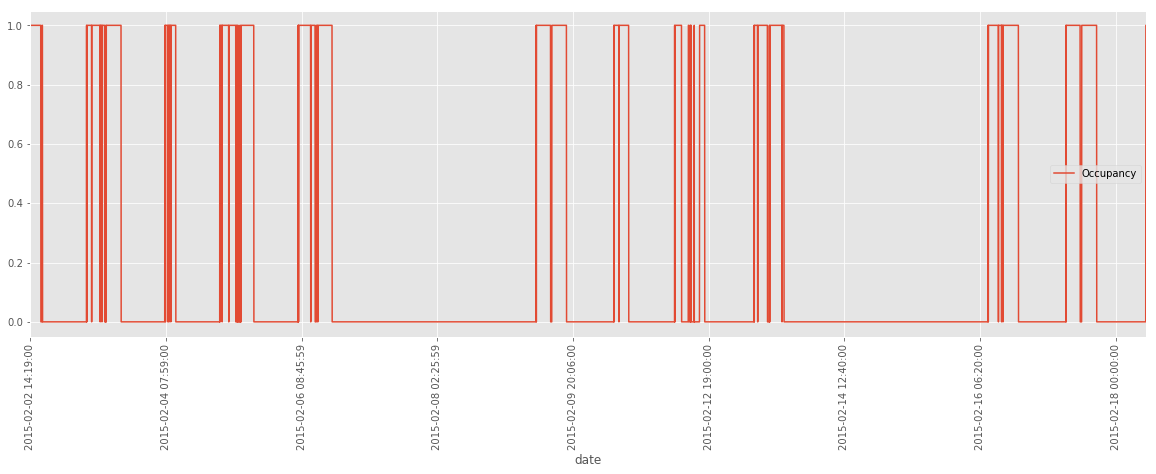

In [58]:
# Now that we have a data frame, let's look at the time series inherent in the data. 
# First, we can examine the first and last measurements

print('First data point: ' + str(min(df['date'])))
print('Last data point: ' + str(max(df['date'])))

# Then, we can look at the pattern of occupancy over time, to get a sense of how important the time feature is. 

df_timeplot = df.sort_values('date')
df_timeplot.plot(x = 'date', y = 'Occupancy', kind = 'line')
plt.xticks(rotation=90)
plt.show()
plt.clf()

## What are we modeling? ##

We can see in the line plot that there are clear, time-related patterns. We see that the room was occupied daily, followed by short periods of disuse (nights) or longer periods of disuse (weekends). Each period has several vertical lines in it, showing that room occupancy changes during the day. Only 4 days were measured in the week starting with Monday the 9th of February. Judging by the pattern, we are missing one weekday of measurements. 

The recurring, time-reated patterns in our data are called 'seasonality'. Occupancy falls around roughly the same hours every weekday, which is seasonality at a daily interval, and there is no occupancy on the weekends, which is weekly sensonality. We could encounter seasonality at other time intervals too, e.g. hourly seasonality when everyone leaves for a smoking break every hour. 

If we want to analyze time series data with seasonal patterns, our model needs to account for seasonality, but also for dependence between events at different timepoints. For example, when there are people in our office room, concentrations of CO2 and moisture will build up gradually, and they will decay over time when these people leave. To account for such effects, we could choose a number of techniques, for example a time series model with a state space decomposition, a hidden markov model, or a recurrent neural network. 

Given that our dataset is:
* describing a time window of limited length;
* collected over a time period that seems to have been interrupted at least once;
* likely collected in the same office space,

we cannot build a model that generalizes over longer periods of time, between various office environments, or between combinations of these factors. *Given these restrictions, our initial objective with this dataset is to construct a model that allows us to describe when the office room in which the sensors were positioned was occupied, based on sensor readings but disregarding their time series properties.* 

In other words, we'll not formally model any seasonality or dependency over time for now, as we don't have enough data points to reliably estimate such effects. This implies that our model will not be useful for predictions, as predictions would require that we know about time. 

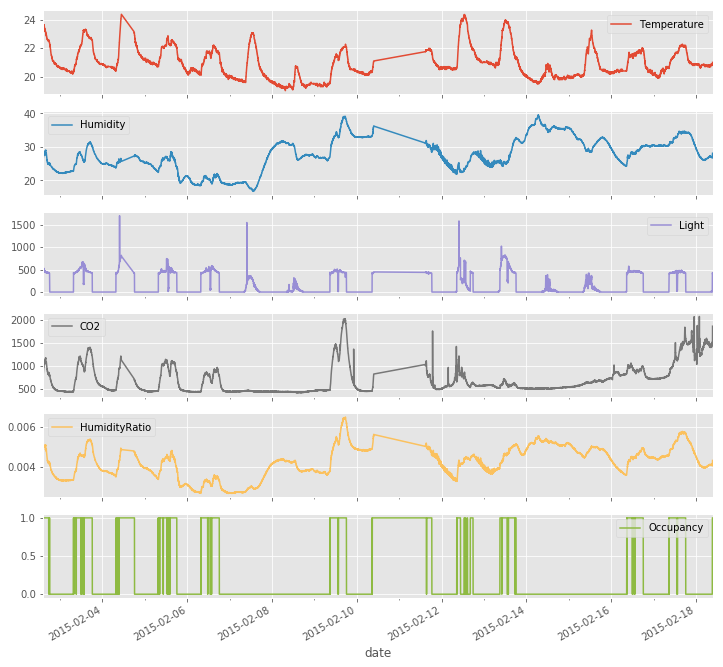

2      581
3     1440
4     1013
5     1440
6     1440
7     1440
8     1440
9     1440
10     574
11     552
12    1440
13    1440
14    1440
15    1440
16    1440
17    1440
18     560
Name: day, dtype: int64


In [59]:
# We can't leave time out of our equations entirely. To account for its influence, we can derive features from
# components of the time stamps in the data set. This allows us to account for variance, but not causality, over time.

# First, we'll change the data type of the 'date' field to datetime

df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d %H:%M:%S')

# This makes it easier to visualize time series for each observed variable by plotting them against time

df.plot.line(x=df['date'], subplots=True, figsize = (12,12))
plt.show()
plt.clf()
    
# Next, we separate out days, hours, minutes.  

df['year']=df['date'].dt.year
df['month']=df['date'].dt.month
df['day']=df['date'].dt.day
df['hour']=df['date'].dt.hour
df['minute']=df['date'].dt.minute

# In some cases, the sensors registered values one to a few seconds early. 
# We'll recode these to accurately represent the minutes they were supposed to express.

df.loc[(df['date'].dt.second > 30),'minute']+=1

# We need to check if we indeed have missing values around 11-02-2015. If this is the case, frequency counts should differ between dates

print(df['day'].value_counts().sort_index())



## Interpreting features over time ##

The plot we have just made tells us a few important things:

* The seasonality we just talked about is visible in clear, recurrent patterns for temperature and light; 
* Measurements took place in three periods, with gaps between the 4th and 5th and the 10th and 12th of February; 
* The target, 'Occupancy', is imbalanced: roughly 25% of samples (4750 out of 20560) involved an occupied room.

We are taking the first two points into account already, by not examining any effects of time. We will also need to correct the measurement imbalance. A first step we can take is to examine weekdays only. This will improve ratio of ocupancy timepoints to non-occupancy time points to roughly 1:2. For a dataset of this size, this ratio would allow most algorithms to make good predictions. However, we may want to estimate occupancy over longer periods of time. Because the data generated will continue to have a roughly 1:2 ratio of ocupied to non-occupied, it makes sense to address the inequality. 

## Three sampling strategies ##

To address the inequality in our target variable, we can try out three strategies: weighting the regularization parameter C, oversampling using SMOTE, or undersampling by random selection. 

When weighting the C parameter, we are using regularization to enhance the effects of support vectors that predict the smaller class, at the expense of support vectors that predict the larger class. This removes bias in the placement of our decision boundary which results from class size differences. 

When we oversample, we generate new, fictional data points for our smaller class. They're built using a k nearest neighbors approach, and distributed equally across the sample space in proximity to the existing data points. Of course, if we would want to include the effects of time on our data, generating new data points close to existing ones could distort the time dimension of the whole set. Until a recent technique for generating new samples within time series becomes available in python, the SMOTE algorithm is a good alternative (see Cao, Li, Woon & Ng, 2013).

When we undersample, we remove samples from our larger class. We do so randomly, so that the deletions are distributed equally across the dimensions of our dataset. We'll face the inverse problem of the oversampling approach above - the continuity of our dataset will suffer because the deltions create discontinuity in our time series. As with oversampling, a technique for applying undersampling to time series data was recently developed (Moniz, Branco & Torgo, 2017). Until it is available in python, however, we will need to make do with randomized deletion.

In sum, each of the above strategies will distort parameter values relative to the original data set. Should we want to make contiuous predictions at a later point in time, we also need to take into account how these techniques affect the time dimensions of our data. We will compare the three methods in this notebook, to see if there are any differences in performance that would lead one of the techniques to be preferred over the others.



In [60]:
# As we have seen above, data for 'Occupancy' seems imbalanced.
# To verify this, we can print descriptives, we should see a mean value < .5 for 'Occupancy' if there is imbalance

print(df.describe())

# We can take out the weekends from our data to reduce the imbalance

print(df.shape)
df = df.loc[((df['date'] < '2015-02-07')|(df['date'] > '2015-02-08')),:]
df = df.loc[((df['date'] < '2015-02-12')|(df['date'] > '2015-02-15')),:]
print(df.shape)

# We can now build a feature to represent weekdays rather than days of the month, 
# and create dummies for the influence of our time variables

df['weekday'] = df['date'].dt.weekday
dummies = pd.get_dummies(df['weekday'], prefix='weekday')
df = pd.concat([df, dummies], axis=1)
dummies2 = pd.get_dummies(df['hour'], prefix='hour')
df = pd.concat([df, dummies2], axis=1)
dummies3 = pd.get_dummies(df['minute'], prefix='minute')
df = pd.concat([df, dummies3], axis=1)

# We can then drop the date and day columns, the (invariant) year and month columns, 
# and the now obsolete 'weekday', 'hour' and 'minute' columns

try:
    df = df.drop(['date', 'day', 'year', 'month', 'weekday', 'hour', 'minute'], axis=1)
except:
    pass
    
print(df.head())

        Temperature      Humidity         Light           CO2  HumidityRatio  \
count  20560.000000  20560.000000  20560.000000  20560.000000   20560.000000   
mean      20.906212     27.655925    130.756622    690.553276       0.004228   
std        1.055315      4.982154    210.430875    311.201281       0.000768   
min       19.000000     16.745000      0.000000    412.750000       0.002674   
25%       20.200000     24.500000      0.000000    460.000000       0.003719   
50%       20.700000     27.290000      0.000000    565.416667       0.004292   
75%       21.525000     31.290000    301.000000    804.666667       0.004832   
max       24.408333     39.500000   1697.250000   2076.500000       0.006476   

          Occupancy     year    month           day          hour  \
count  20560.000000  20560.0  20560.0  20560.000000  20560.000000   
mean       0.231031   2015.0      2.0     10.073249     11.446887   
std        0.421503      0.0      0.0      4.729430      7.075840   
min

In [61]:
# Let's select whether we will compensate for category inequality by weighting, undersampling, or oversampling
# 0 means we will weight the C parameter; 
# 1 means we will oversample using SMOTE; 
# 2 means we will undersample using random selection.

WeightOrSample = 2 

In [62]:
# Sample weighting: Specify a weight in SVC() function call below to balance out the C paramter  

if (WeightOrSample==0):
    X = df.drop('Occupancy', axis = 1)
    y = df['Occupancy']
    dfCorr = pd.concat([y, X], axis=1)
    labels = ['red' if i==0 else 'green' for i in dfCorr.Occupancy]
    print(dfCorr.shape)

# Oversampling: Use SMOTE to bootstrap cases with value 'Occupied'    

elif (WeightOrSample==1):    
    from imblearn.over_sampling import SMOTE
    ratios = {1:4700, 0:5000}
    X = df.drop('Occupancy', axis = 1)
    y = df['Occupancy']
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_sample(X,y)
    X = pd.DataFrame(X_res, columns = X.columns)
    y = pd.Series(y_res, name = 'Occupancy')
    dfCorr = pd.concat([y, X], axis=1)
    labels = ['red' if i==0 else 'green' for i in dfCorr.Occupancy]
    print(dfCorr.shape)
    
# Undersampling: Using random selection to undersample

elif (WeightOrSample==2):
    tmp = df.loc[df['Occupancy']==0]
    targetCount = df.loc[df['Occupancy']==1].shape[0]
    getIndexValues = np.random.choice(tmp.index.values, targetCount)
    tmpSelected = tmp.iloc[getIndexValues,:]
    dfCorr = pd.concat([df.loc[df['Occupancy']==1], tmpSelected], axis=0)
    X = dfCorr.drop('Occupancy', axis = 1)
    y = dfCorr['Occupancy']
    labels = ['red' if i==0 else 'green' for i in dfCorr.Occupancy]
    print(dfCorr.shape)

# Check the 'Occupancy' ratio

print(dfCorr['Occupancy'].describe())

(8024, 97)
count    8024.000000
mean        0.500000
std         0.500031
min         0.000000
25%         0.000000
50%         0.500000
75%         1.000000
max         1.000000
Name: Occupancy, dtype: float64


Descriptives:

       Temperature     Humidity        Light          CO2  HumidityRatio  \
count  8024.000000  8024.000000  8024.000000  8024.000000    8024.000000   
mean     21.250506    27.333784   238.305698   853.562785       0.004281   
std       0.932662     4.657602   235.220891   383.174270       0.000806   
min      19.200000    18.390000     0.000000   414.500000       0.002674   
25%      20.633333    24.200000     0.000000   487.000000       0.003695   
50%      21.200000    27.125000   405.000000   801.125000       0.004321   
75%      21.890000    30.600000   449.500000  1088.925000       0.004860   
max      24.408333    39.117500  1697.250000  2072.000000       0.006476   

         Occupancy  
count  8024.000000  
mean      0.500000  
std       0.500031  
min       0.000000  
25%       0.000000  
50%       0.500000  
75%       1.000000  
max       1.000000  


Missing value counts:

Temperature      0
Humidity         0
Light            0
CO2              0
HumidityRa

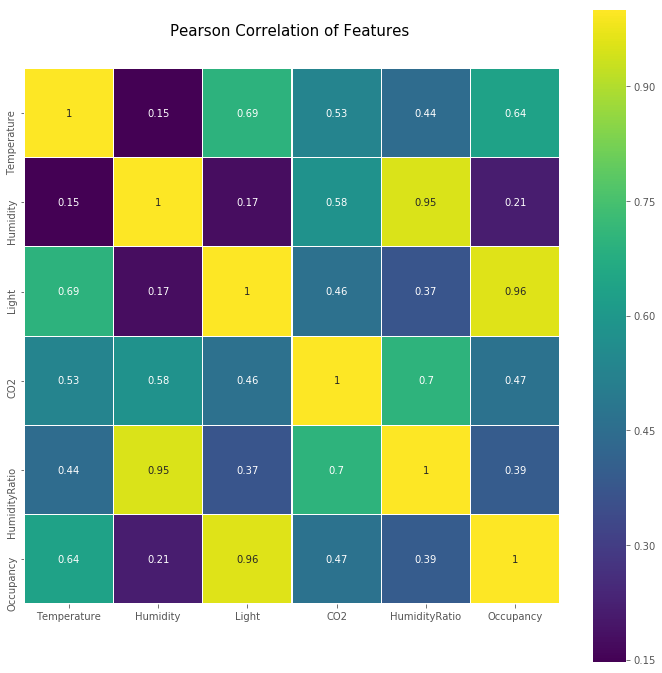




Temperature
Temperature      1.000000
Light            0.693488
CO2              0.530921
HumidityRatio    0.444310
Occupancy        0.639493
weekday_6       -0.477905
Name: Temperature, dtype: float64



Humidity
Humidity         1.000000
CO2              0.581092
HumidityRatio    0.950207
weekday_4       -0.616229
Name: Humidity, dtype: float64



Light
Temperature    0.693488
Light          1.000000
CO2            0.461704
Occupancy      0.958694
Name: Light, dtype: float64



CO2
Temperature      0.530921
Humidity         0.581092
Light            0.461704
CO2              1.000000
HumidityRatio    0.698546
Occupancy        0.468178
Name: CO2, dtype: float64



HumidityRatio
Temperature      0.444310
Humidity         0.950207
CO2              0.698546
HumidityRatio    1.000000
weekday_4       -0.577641
Name: HumidityRatio, dtype: float64



Occupancy
Temperature    0.639493
Light          0.958694
CO2            0.468178
Occupancy      1.000000
Name: Occupancy, dtype: float64


In [63]:
# Let's get a sense of the dependencies between our sensor data by examining descriptives and correlations for measurement data
print('Descriptives:\n')
print(dfCorr.iloc[:,0:6].describe())
print('\n\nMissing value counts:\n')
print(dfCorr.iloc[:,0:6].isnull().sum())
print('\n\nFeature correlations:\n')

# Plot correlation of each of the features with every other feature 
dfPlot = dfCorr.iloc[:,0:6]
correlation_heatmap(dfPlot)

# Let's see if any correlations greater than .4 or smaller than -.4 exist between sensor measurement data and time data
dfTimecorr = dfCorr.corr()
dfTimecorr = dfTimecorr.iloc[:,0:6]
for col in dfTimecorr:
    print('\n\n')
    print(col)
    print(dfTimecorr.loc[((dfTimecorr[col]>.4)|(dfTimecorr[col]<-.4)), col])

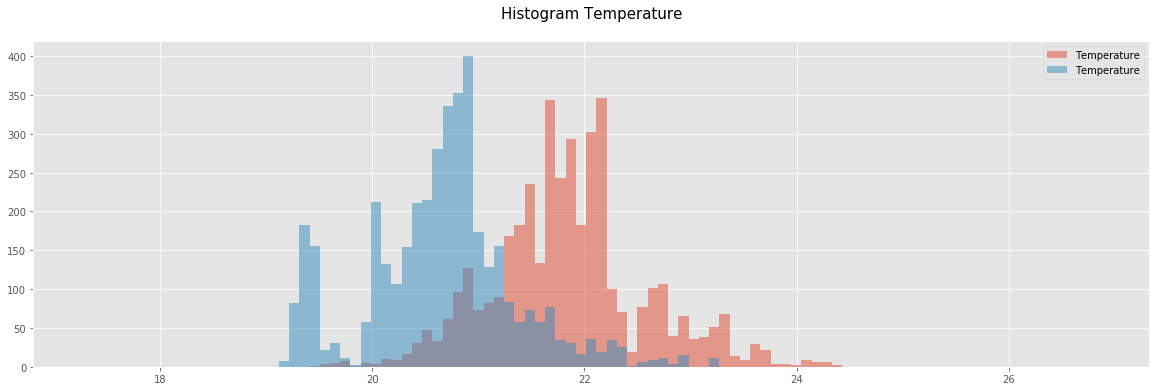

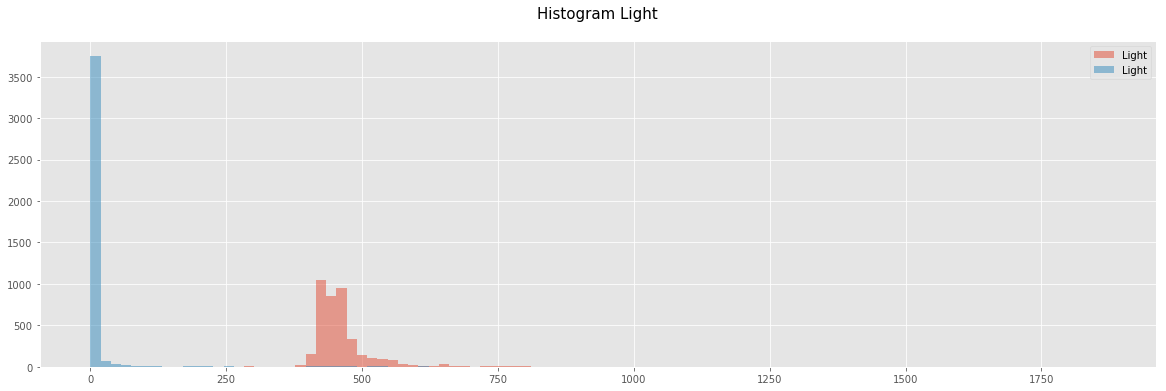

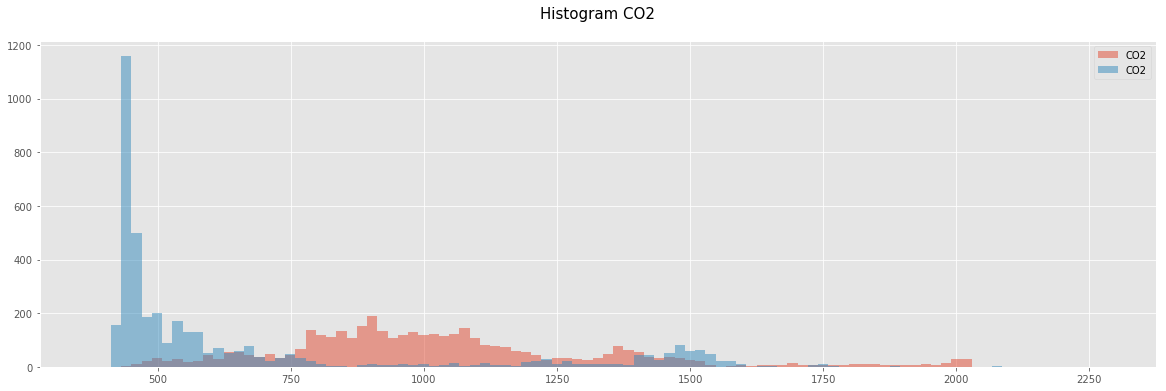

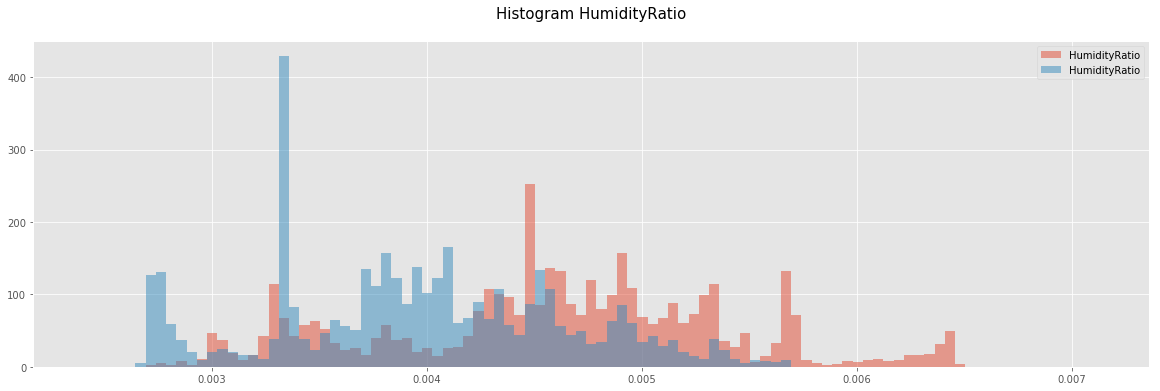

In [64]:
# Based on the correlations above, we can drop the 'Humidity' feature from the model. 
# The 'Humidity ratio' feature is derived from this feature, but unlike 'Humidity ratio', 
# 'Humidity' is not correlated with our target.

# By excluding 'Humidity', we prevent that shared variance between 'Humidity' and 'Humidity Ratio' 
# distorts effects of variance-dependent techniques like Principal Component Analysis. 
# Doing so also makes our model more simple.

dfCorr = dfCorr.drop('Humidity', axis=1)

# Next, let's plot histograms for each feature that was originally in the DataFrame organized by occupancy 
# to visualize relationships
plt.close('all')
numvar_hist(dfCorr.iloc[:,0:5], 'Occupancy')


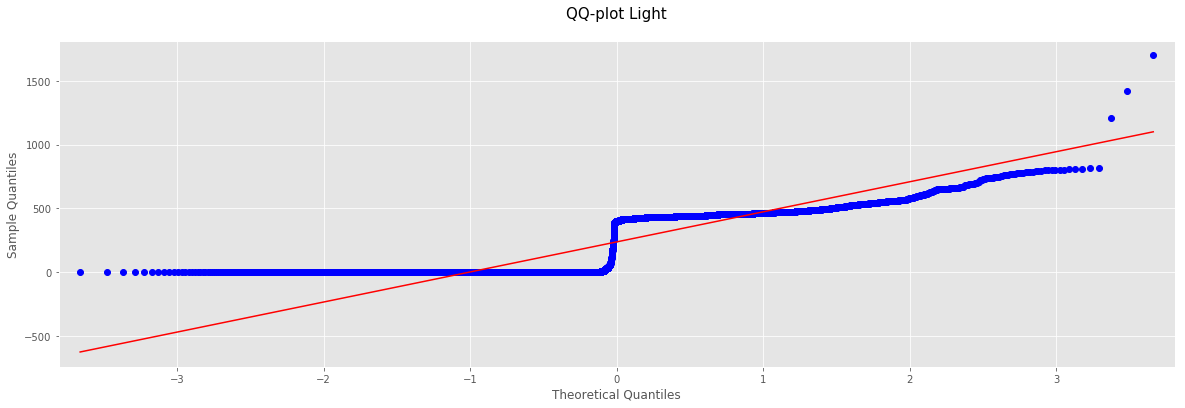

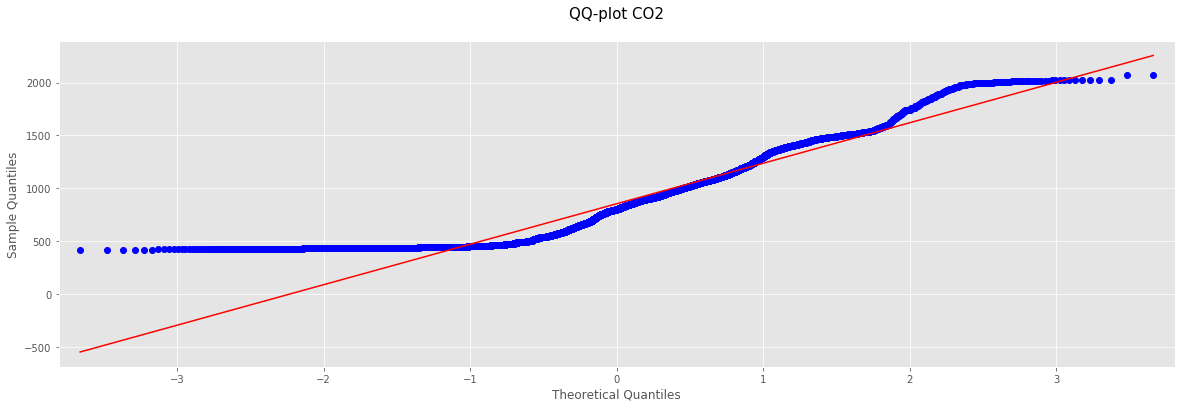

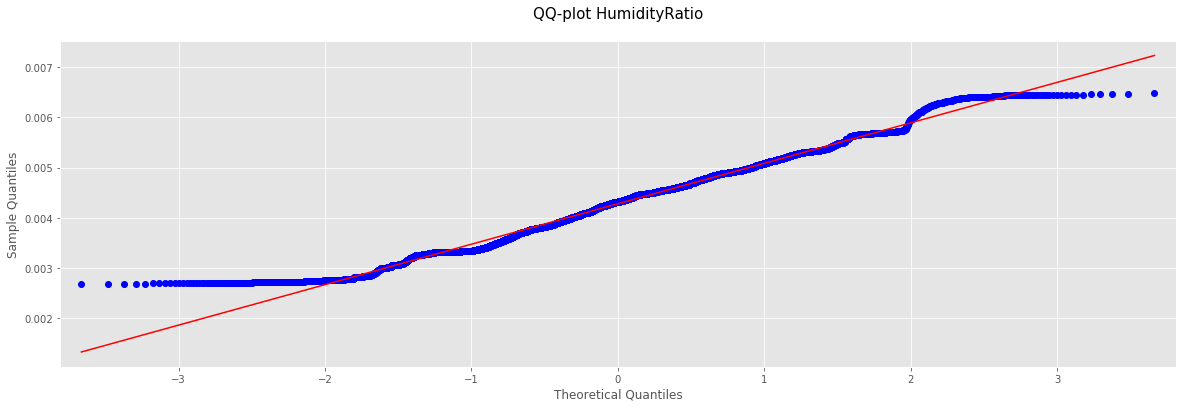

In [65]:
# For a more formal check of normality, we can also plot a QQ plot, which depicts a the comparison between our observations and a probability distribution.
for col in dfCorr.iloc[:,1:5].columns:
    if col == 'Occupancy':
        pass
    else:
        qqplot(dfCorr[col], line='s')
        plt.title(('QQ-plot ' + str(col)), y=1.05, size=15)
        plt.show()
        plt.clf()

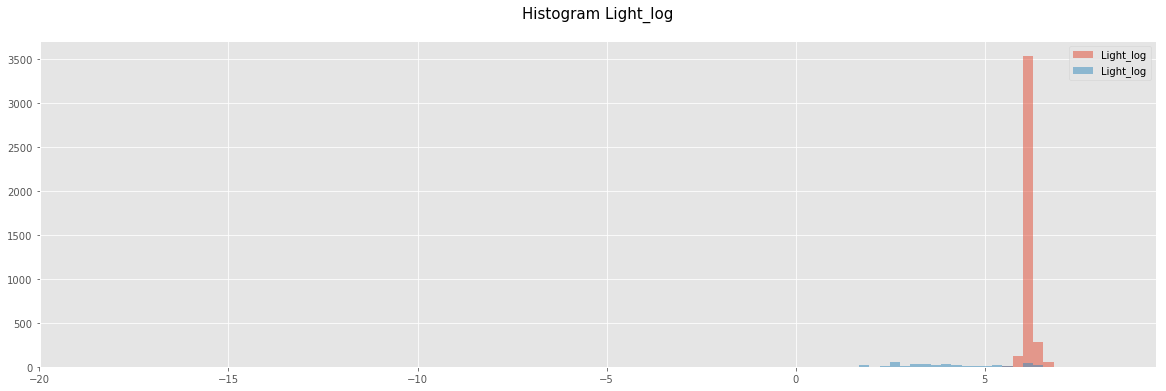

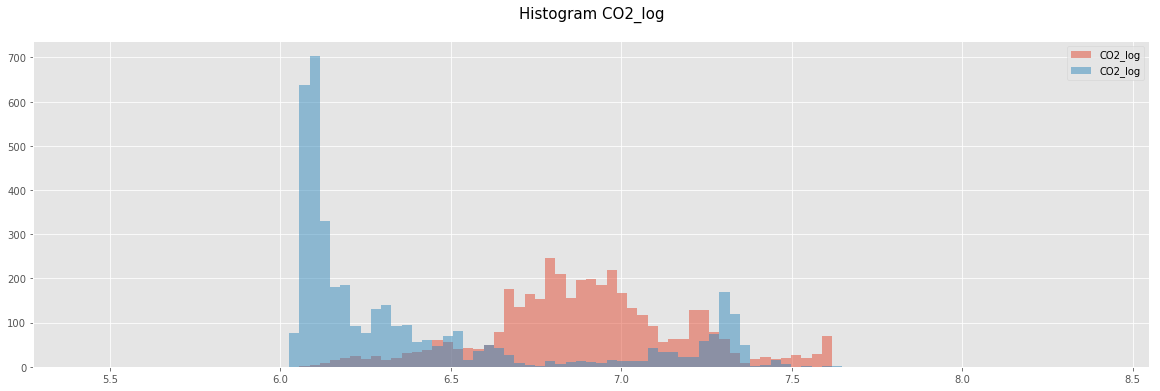

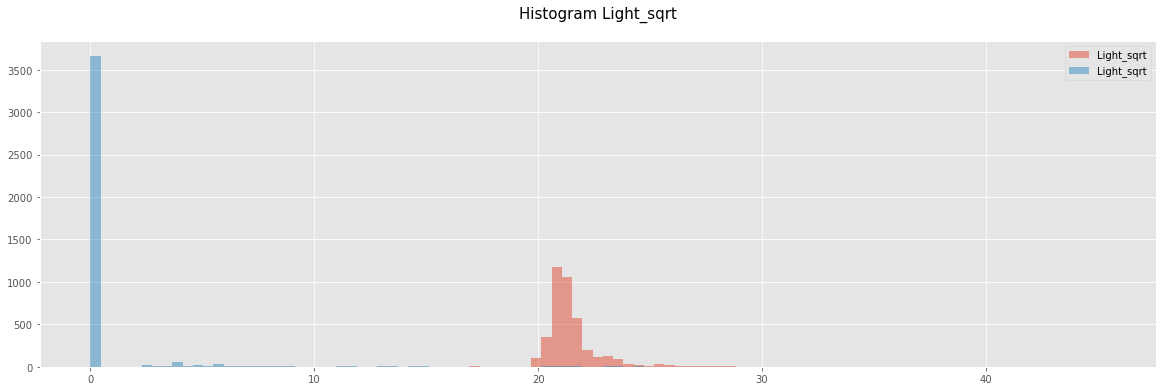

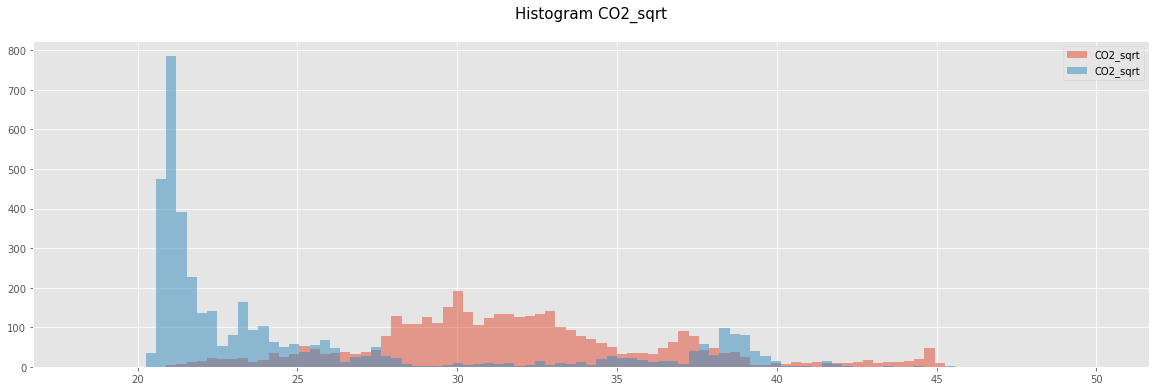

In [66]:
# We can see that the measurements for features 'Light' and 'CO2' are not normally distributed. 
# Fortunately, this is not a problem when using a Support Vector Classifier, 
# as it applies the probability distribution to the geometrical positions of observations 
# relative to a kernel in multidimensional space and not to the features themselves.
# We can still attempt to normalize these features as follows:

dfCorr.loc[dfCorr['Light']==0, 'Light']=0.000000001
dfCorr.loc[dfCorr['CO2']==0, 'CO2']=0.000000001

dfCorr['Light_log'] = np.log(dfCorr['Light'])
dfCorr['CO2_log'] = np.log(dfCorr['CO2'])

dfCorr['Light_sqrt'] = np.sqrt(dfCorr['Light'])
dfCorr['CO2_sqrt'] = np.sqrt(dfCorr['CO2'])

plt.close('all')
numvar_hist(dfCorr.loc[:,['Light_log', 'CO2_log', 'Light_sqrt', 'CO2_sqrt', 'Occupancy']], 'Occupancy')

dfCorr = dfCorr.drop(['Light_log', 'CO2_log', 'Light_sqrt', 'CO2_sqrt'], axis=1)
# As we can see in the plots, neither type of transformation yields improvement toward normality for Light or CO2 variables
# Tried with variations of root (**(1./<coefficient>)) and power **<coefficient>)


In [67]:
# To view a scale-independent depiction of multivariate feature space, we can now plot andrews curves. 
# numvar_andrews_curves(dfCorr, 'Occupancy') #Commented out due to calculation load


## Selecting and representing features ##

Our dataset now has four indicators which correlate with occupancy (Light, Temperature, CO2, and Humidity ratio). The most parsimonious model out of these variables would likely be one based on 'Light' alone, as this feature has a correlation of .95 to our target 'Occupancy'. A parsimonious model (including 'Light' as the only variable) trades off with sensor validity, the extent to which the model can handle errors in measurement by one or more sensors. 

To illustrate, suppose we build a model that depends exclusively on whether or not a room has a certain value of light in lux. It's 18:00 PM, the people in our measurement office go home for the day, and the last person forgets to turn off the light. Our model is now essentially receiving sensor ratings that are not valid, i.e. do not accurately reflect our criterion of interest. If our model includes just one factor, it will now misclassify. If our model includes four factors instead, the combined variance of the other three factors may allow the model to compensate.

## Re-composing features ##
Our correlation matrix shows that some of our sensor ratings tend to go together. Support vector classifiers are generally robust to multicollinearity. If we want to exclude its influence entirely, we can use principal component analysis to decompose our continuous, highly correlated features into linearly independent features. If desirable, we could also use principal component analysis for reducing the number of continuous features in our dataset (although this is currently not very useful with all of the dichotomous features representing time levels).  

We'll need to scale our features before putting them through PCA. If we want to use principal component analysis, our continuous data also need to follow a multivariate normal distribution. We'll include these two points as steps below.

In [68]:
# First, let's scale our features, and subset the continuous ones (checking if they were re-scaled).

dfCorr = dfCorr.reset_index(drop=True)
y = dfCorr['Occupancy']
X = dfCorr.drop(['Occupancy'], axis=1)
print(X.iloc[:,0:4].describe())
X = scale_features_df(X)
tmp = X.iloc[:,0:4]
print(tmp.describe())

# Next, we need to check if the continuous feature set has multivariate normality

dimmean = np.mean(tmp, axis=0)
dimcov = tmp.cov()

mvnorm = pd.Series(multivariate_normal.pdf(tmp, mean=dimmean, cov=dimcov)).sort_values()

print('\n\n')
print('Multivariate normality if statistic < .05: ')
print(mvnorm.max())
print('\n\n')
print('Number of violations out of ' + str(mvnorm.shape[0]) + ' observations: ')
print(mvnorm.loc[mvnorm > .05].count())

# With a maximum value below the conventional .05 threshold, the data can be assumed to be multivariate normal.

       Temperature         Light          CO2  HumidityRatio
count  8024.000000  8.024000e+03  8024.000000    8024.000000
mean     21.250506  2.383057e+02   853.562785       0.004281
std       0.932662  2.352209e+02   383.174270       0.000806
min      19.200000  1.000000e-09   414.500000       0.002674
25%      20.633333  1.000000e-09   487.000000       0.003695
50%      21.200000  4.050000e+02   801.125000       0.004321
75%      21.890000  4.495000e+02  1088.925000       0.004860
max      24.408333  1.697250e+03  2072.000000       0.006476
        Temperature         Light           CO2  HumidityRatio
count  8.024000e+03  8.024000e+03  8.024000e+03   8.024000e+03
mean  -3.712063e-15  2.445031e-14 -1.182794e-16  -5.224579e-17
std    1.000062e+00  1.000062e+00  1.000062e+00   1.000062e+00
min   -2.198689e+00 -1.013178e+00 -1.145928e+00  -1.994890e+00
25%   -6.617734e-01 -1.013178e+00 -9.567073e-01  -7.281350e-01
50%   -5.415574e-02  7.087155e-01 -1.368595e-01   4.901414e-02
75%    6.8

We can't make a strong assumption of multivariate normality, but the maximum observed probability value suggests the data approach the conventional threshold. This means that we can still apply principal component analysis, but we'll have to keep in mind that the linear decomposition of the feature space may not capture any non-linear effects that may exist in the dataset (as evidenced by the violation of assumptions of multivariate non-normality).

As feature reduction is not a goal of our decomposition, let's decompose the continuous features in our feature space into a same number of features. In other words, we are only re-distributing variance to a linearly independent collection of predictors. 

('Variance explained by derived components: ', array([ 3.70121429,  1.80545955,  1.44933283,  1.33571708]))


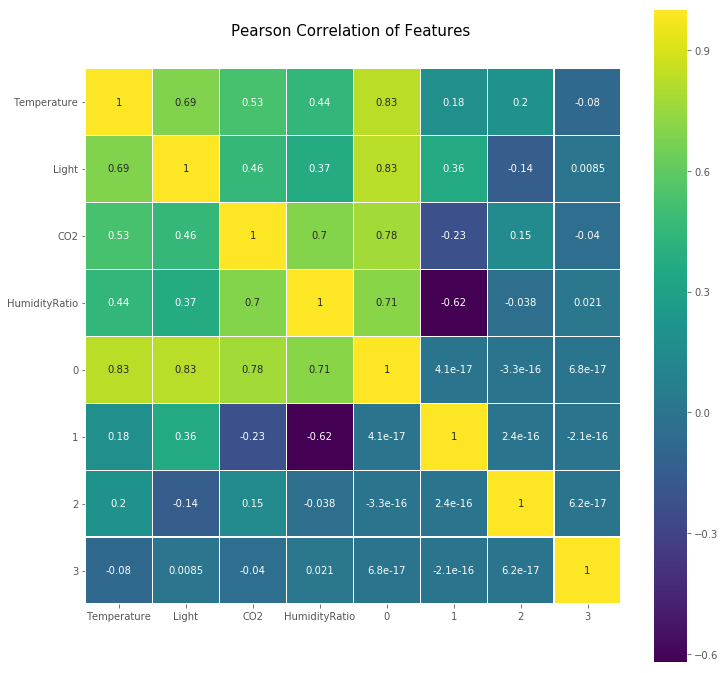

In [69]:
# We'll now apply PCA to our continuous features.

X_continuous = X.iloc[:,0:4]
pca = PCA(n_components = X_continuous.shape[1])
pca_4 = pca.fit(X_continuous)
pca_T = pca.fit_transform(X)
print("Variance explained by derived components: ", pca_4.explained_variance_)

# To view how the components relate to our original variables, we can correlate resulting components 
# with original features.

plot_correlations = pd.concat([X.iloc[:,0:4], pd.DataFrame(pca_T)], axis=1)
correlation_heatmap(plot_correlations)


## Principal Component Analysis ##

We have seen the correlations between the original features, in the upper left quadrant, before in an earlier heatmap. The relations between the components 0 through 3, that resulted from the PCA (lower right quadrant) all approach 0, reflecting statistical independence of orthogonal components. 

If we look at the lower left or upper right quadrants (they are mirrored across the diagonal), we can see that the most important predictor is a combination of high temperature, strong light, a high level of CO2, and a high humidity ratio. The second component is the absence of humidity in the presence of temperature and light. The third and fourth components do not seem to relate meaningfully to the original components in terms of variance. This pattern is similar across the three types of sampling strategy.

('Features by importance:\n', [(2.2568107139856215, 'HumidityRatio'), (2.005754254166819, 'Light'), (1.8258429489187837, 'Temperature'), (1.7516017176999483, 'CO2')])


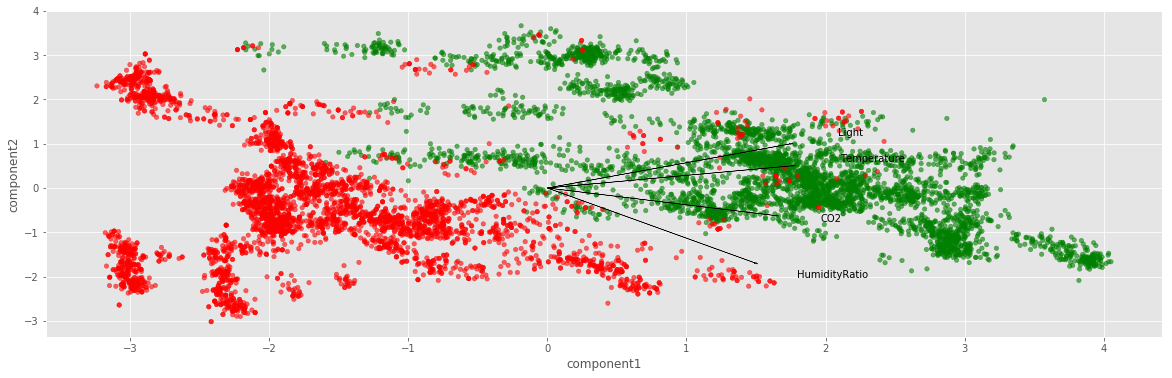

In [70]:
# We can visualize how effective PCA was in finding components in the data set, 
# and visualize relations between component socres and occupancy

ax = draw_vectors(pca_T, pca.components_, X_continuous.columns.values, plt)
T  = pd.DataFrame(pca_T)

T.columns = ['component1', 'component2', 'component3', 'component4']
T.plot.scatter(x='component1', y='component2', marker='o', c=labels, alpha=.60, ax=ax)

plt.show()


## Interpreting the Principal Component Analysis plot ##

It seems that for the moments at which the room is occupied, we get two clusters of values. One scores relatively high on component 2, and low to moderate on component 1, the other scores high on component 1, but relatively low on component 2. Note that when SMOTE is used, the number of green points in the graph is higher than it would normally be, as we have oversampled the 'occupied' category, and when undersampling is used the number of red points is lower than it would normally be as we have undersampeled the 'not occupied' category.

We can interpret the correlations between the components and the original variables in the data set. All values for the features that correlate with components 1 and 2 (higher values for all sensor readings for component 1, and higher light and temperature values, but lower humidity readings (in ratio) for component 2) are, on average, higher for occupied rooms than they are for non-occupied rooms. 

It is important to recognize that the graph constructed here only displays the first two components of the data set, or, in other words, the first two dimensions of the n-dimensional space. Plots can also be made for the remaining components, but as the components are ordered by the amount of variance they explain this graph depicts the two most important components in terms of variance and is therefore the most informative. 


In [71]:
# We can combine the components obtained with PCA with the features representing time,
# and visualize the distribution of occupancy over predictors in on the continuous features with andrews curves.
# Given the large number of time variables, we won't include them in the plot so as not to clutter it.

tmp = X.iloc[:,4:]
X = pd.concat([T, tmp], axis=1)
dfUse = pd.concat([X, y], axis=1)
# numvar_andrews_curves(dfUse[:,0:3], 'Occupancy') #Commented out due to calculation load

In [72]:
# Now that our feature set is ready for analysis, let's define training, testing and validation subsets

train, test = train_test_split(dfUse, test_size = .4, stratify=dfUse['Occupancy'])
test, validate = train_test_split(test, test_size = .5, stratify=test['Occupancy'])

X_train = train.drop('Occupancy', axis=1)
y_train = train['Occupancy']
X_test = test.drop('Occupancy', axis = 1)
y_test = test['Occupancy']
X_val = validate.drop('Occupancy', axis = 1)
y_val = validate['Occupancy']

In [73]:
# Next, we can fit our predictive model to training set, and examine the evaluation metrics

# To do so, we calculate the initial fit of the model, and print diagnostics
# for undersampling or oversampling:

if (WeightOrSample==1)|(WeightOrSample==2):
    clf = SVC(kernel = 'linear')
    svm = clf.fit(X_train,y_train)
    
    print('Initial training score: '+str(svm.score(X_train,y_train)))
    print('\n')
    print('Initial test score: '+ str(svm.score(X_test,y_test)))
    print('\n')
    
    y_pred = svm.predict(X_test)
    
    print('Classification report: ' + str(classification_report(y_test, y_pred)))
    print('\n')
    print('Confusion matrix: ' + str(confusion_matrix(y_test, y_pred)))
    print('\n')

# for parameter weighting:
    
elif WeightOrSample==0:
    clf = SVC(kernel = 'linear', class_weight = 'balanced')
    svm = clf.fit(X_train,y_train)
   
    print('Initial training score: ', str(svm.score(X_train,y_train)))
    print('\n')
    print('Initial test score: ', str(svm.score(X_test,y_test)))
    print('\n')
    
    y_pred = svm.predict(X_test)
    
    print('Classification report: ' + str(classification_report(y_test, y_pred)))
    print('\n')
    print('Confusion matrix: ' + str(confusion_matrix(y_test, y_pred)))
    print('\n') 

Initial training score: 0.989821354383


Initial test score: 0.995638629283


Classification report:              precision    recall  f1-score   support

          0       1.00      0.99      1.00       803
          1       0.99      1.00      1.00       802

avg / total       1.00      1.00      1.00      1605



Confusion matrix: [[796   7]
 [  0 802]]




## Initial results ##

It seems our model, which has not been tuned yet, is performing quite well on the training data:
* For the parameter weighting approach, an observed training score was .99, with 36 errors out of 2960 classified data points
* For the oversampling approach, an observed training score was .99, with 39 errors out of 4314 classified data points
* For the undersampling approach, an observed training score was .99, with 14 errors out of 1605 classified data points

For the parameter weighting model, there is a slight drop in precision for the smaller clas of the 'Occupancy' variable, which could be due to a relative lack of data points. This is not very important now, but is good to know when training this model on, say, continuous sensor data.

Let's examine our model's performance at various levels of C and using cross-validation, so that we can assess whether its good performance is due to overfitting of the training data. If it is, we would expect lower test set performance than training set performance.

In [74]:
# Please note this next step will take some time to execute!

# We can use GridSearchCV to search for optimal parameter values and 
# prevent overfitting by implementing cross-validation

# First, we'll specify hyperparameters C and gamma to feed to GridSearchCV

params = [{'C': [.00001, .0001, .001, .01, 1, 10], 'gamma':[.00001, .0001, .001, .01, 1, 10]}] 

# An optional addition to 'parameters' is to vary kernel using ",'kernel':['rbf', 'poly', 'linear', 'sigmoid']". 
# It was left out to lessen calculation time, as 'rbf' proved optimal in an earlier, more complete run. 

# Next, let's specify our base classifier

if (WeightOrSample==1)|(WeightOrSample==2):
    clf2 = GridSearchCV(SVC(), params, refit=True)
elif WeightOrSample==0:
    clf2 = GridSearchCV(SVC(class_weight = 'balanced'), params, refit=True)

# And fit the optimal model

svm2 = clf2.fit(X_train, y_train)
scores = pd.Series(svm2.cv_results_['mean_train_score'])

# To finally save the best estimator for future use

bestEst = svm2.best_estimator_

In [75]:
# We can also print the results of our training session

for key in svm2.cv_results_:
    print(key)
    print(svm2.cv_results_[key])
    print('\n\n')

print("Best estimation: " + str(svm2.best_estimator_))
print('\n')

print("Best test score achieved:" + str(svm2.best_score_))
print('\n')

print("Average accuracy across models: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

std_train_score
[ 0.00217468  0.00194533  0.00197932  0.00164345  0.00105873  0.00574288
  0.00217468  0.00194533  0.00197932  0.00164345  0.00105873  0.00574288
  0.00217468  0.00194533  0.00197932  0.00164345  0.00105873  0.00574288
  0.00217468  0.00194533  0.00197932  0.00164345  0.00105873  0.00574288
  0.00217468  0.0023093   0.00219101  0.00173358  0.0001469   0.          0.0023093
  0.00219101  0.00051301  0.00038882  0.          0.        ]



rank_test_score
[16  8 21  8 27 33 16  8 21  8 27 33 16  8 21  8 27 33 16  8 21  8 27 33 16
  5  6  3 26 32  4  6  1  2 25 31]



split0_train_score
[ 0.95355362  0.95355362  0.95355362  0.95604738  0.99875312  0.62874065
  0.95355362  0.95355362  0.95355362  0.95604738  0.99875312  0.62874065
  0.95355362  0.95355362  0.95355362  0.95604738  0.99875312  0.62874065
  0.95355362  0.95355362  0.95355362  0.95604738  0.99875312  0.62874065
  0.95355362  0.96602244  0.95854115  0.97506234  0.99968828  1.
  0.96602244  0.95854115  0.98316708 

##Additional results ##

### Performance for parameter weighting
Best performing model was:

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Best test score: .985

Weighting the C parameter maintains the imbalance in the dataset when training. This translates to an average accuracy that is low compared to those for under over- and undersampling.


### Performance for oversampling

Best performing model was: 

SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
  
Best test score: .989

### Performance for undersampling

Best performing model was:

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Best test score: .978

Undersampling removes variance from the dataset. This translates to an average accuracy that is inflated compared to those for parameter weighting and oversampling.



We can see that for each type of analysis the optimal model is the same, with a final accuracy of >.97 in all cases. At the same time, the training and testing data from the cross-validation rounds show that we have still not been able to exclude the possibility of overfitting. 

The gamma parameter is equal to .001 for all types of analysis, which means the data points in our sample have a reasonable sphere of influence (i.e. impact on the probabilities of their nearest neighbours) in model calculation. At 10, the value for the C parameter is relatively high, meaning little regularization is used. 

Next, let's test the performance of our estimator on the validation set. This should inform us about the extent to which the model overfits.

In [76]:
# To test performance on data the model has not seen before, let's use the optimal estimator 
# to predict the validation set

y_pred = svm2.predict(X_val)

# Of ourse we need to evaluate the predictions

print('Test score: ' + str(svm2.score(X_val, y_val)))
print('\n')

print('Classification report: ' + str(classification_report(y_val, y_pred)))
print('\n')

print('Confusion matrix: ' + '\n' + str(confusion_matrix(y_val, y_pred)))

Test score: 0.983177570093


Classification report:              precision    recall  f1-score   support

          0       0.99      0.97      0.98       802
          1       0.97      0.99      0.98       803

avg / total       0.98      0.98      0.98      1605



Confusion matrix: 
[[780  22]
 [  5 798]]


## Validation results ##

### Parameter weighting

Score on validation set: .99

35 classification errors in 2960 classifications.


### Oversampling

Score on validation set: .990

41 classification errors in 4315 classifications.

### Undersampling

Score on validation set: .982

29 classification errors in 1605 classifications.

There are no noteworthy differences between models here, apart from the decreased precision for parameter weighting on the smaller ('Occupied') category of the 'Occupancy' variable.

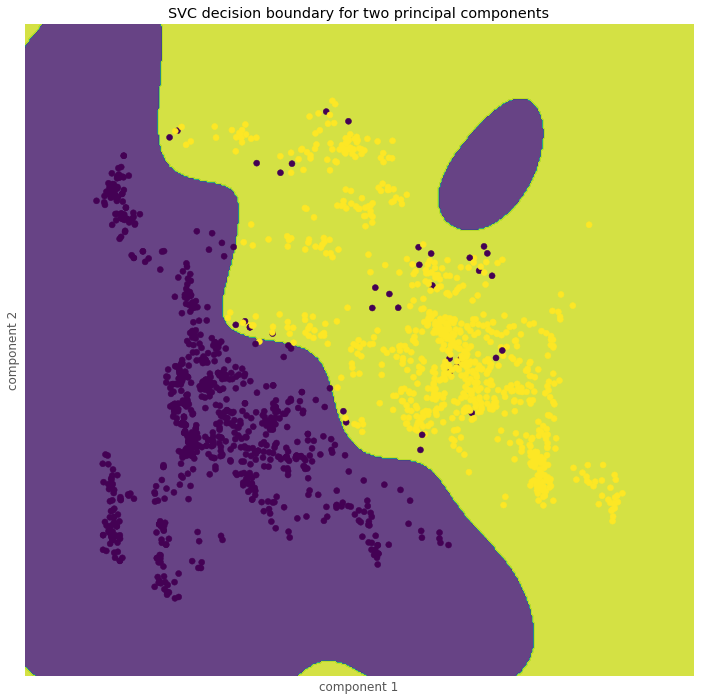

In [77]:
# We can visualize model performance by plotting the decision function on the principal 
# two components in the optimal model

decision_function_2f(svm2, X_val, y_val)

Here, we can see the decision boundaries for the two principal components of the model plotted. Some of the data points still seem to fall in the decision space of the other color. This partly shows the influence of the other components, and may partly be attributed to our inability to capture a high-dimensional space accurately in a 2-dimensional plot.

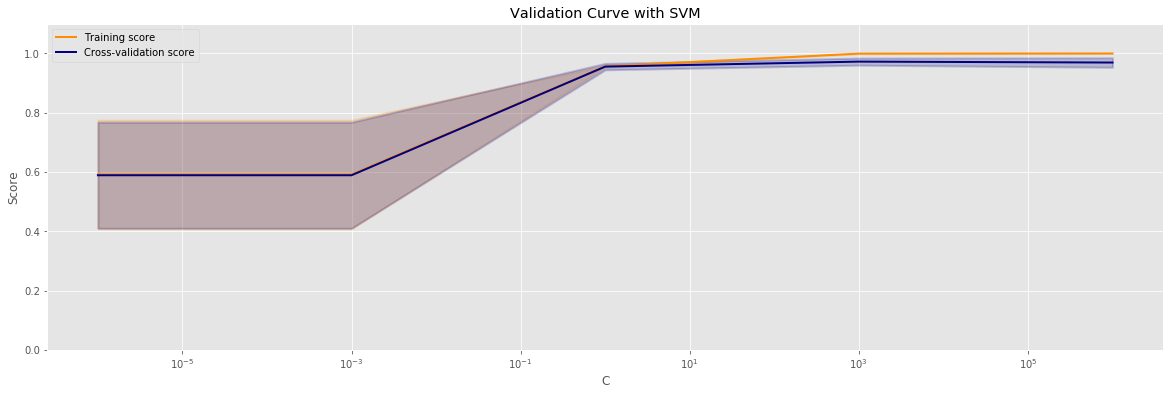

In [78]:
# Please note this step will take some time to execute!

# Having examined various classification metrics and the confusion matrix, we can also 
# view validation curves for the various parameters in the model, based on test set performance.

parameterList = ['C', 'gamma']
plot_validation_curve(bestEst, X_val, y_val)


## Validation curves ##

We can see that the parameter weighting, oversampling and undersampling approaches look similar. As we know, differences in the underlying data points are based on randomized changes. This ensures that the distribution of variance across the models does not differ much in terms of structure.  

The curves show that a C of 10 is the point at which where both testing and cross-validation curves decrease their incline markedly, because they near the maximum value of 1.0. As we increase the C parameter, we reduce the width of the margin that the support vector machine is solving for, by selecting only the most influential (i.e. margin-defining) support vectors. This leads to the inclusion of less data points in calculation of the margin (only those closest to the optimal margin) for determining the margin's location. We can see in the plot that at C = 10, we near the optimal weighting of support vectors for this model.

For the gamma value, the curves for both training and cross-validation performance incline until a value of .001. Beyond this point (i.e. for larger values of gamma) performance on the training set stays constant. Gamma controls the tradeoff between variance and bias. This plot shows that as gamma increases beyond .001 and the width (range) of the rbf kernel decreases, performance on the training set does not suffer. However, performance on the cross-validation set does drop, because the classification of its (new) data points becomes more difficult for the trained model when the range of the rbf kernel becomes smaller (more bias is introduced and variance is not taken into account as much). Comparing this drop across models, it is less pronounced under parameter weighting, when samples are of unequal size and the impact of variance reduction can be assumed to be smaller.

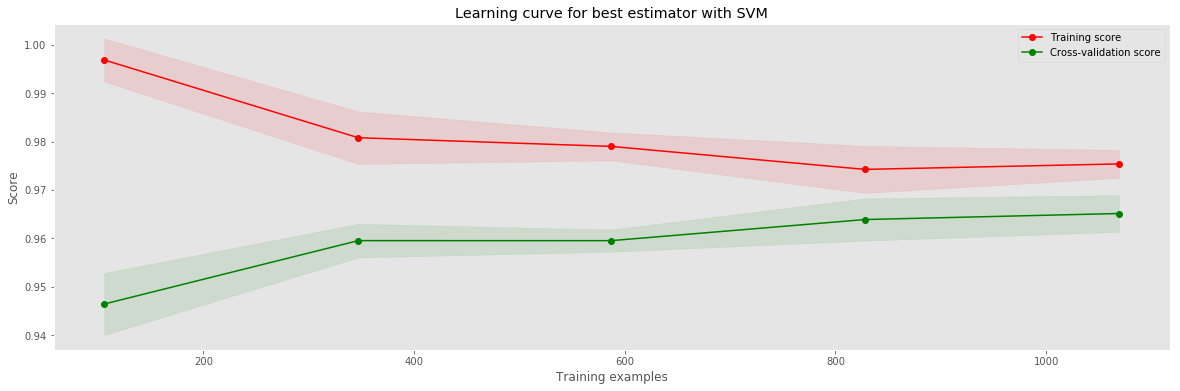

In [79]:
# Please note this step will take some time to execute!

# In addition to the validation curve for this model, the learning curve can show us 
# if we have optimized the tradeoff between bias and variance.

plot_learning_curve(bestEst, "Learning curve for best estimator with SVM", X_val, y_val, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5))

## Learning curve ##

The learning curve depicts how much the model 'learns' when new information is added, by comparing the results for the testing and training sets. The algorithm does so by randomly selecting subsamples from both sets, that increase in size. As the number of training examples increases, the law of large numbers should bring testing and training scores to converge to the point of meeting. If the lines do not meet or meet at a low value, this implies that the estimator used on the training data is not complex enough to explain the data in the test set. In other words, the model suffers from high bias, or conversely, low variance. 

Differences between our three techniques for imbalanced data are small, as each model converges roughly at the .975 mark. The lines in the oversampling scenario suggest that more data may lead to improvements in cross-validation performance, whereas for both C parameter weighting and undersampling the model has converged. 


## Comparing parameter weighting, oversampling, and undersampling ##

We've been using three different techniques for dealing with imbalanced data. The differences observed between them have been minimal. Perhaps this is because the imbalance was slight (+/- 25% positive target observations and +/- 75% negative target observations), perhaps differences did not become apparent because the fitted models neared optimal performance. At any rate, the only meaningful difference we observed was a slight reduction in precision in predicting the label 'Occupied' for the parameter weighting approach.  When considering continuous measurement in the case of real-time room occupancy predictions, the current data suggest all three methods could be used. 

For predictions which involve a decomposition of time series, it is important to realize that manipulating the data points by either over- or undersampling will either generate additional points at certain time stamps, or randomly remove certain timestamps from the dataset. Either of these solutions will create discontinuity in the time series, making it more difficult to reliably estimate effects of time. If we would want to use a support vector machine to make continuous predictions of room occupancy, it therefore seems best to implement the parameter weighting approach.

## Broader considerations ##

We have looked at measures taken in one office space, without knowing the number of people present. We have also had to estimate a model without including a time series component, as the measurement period was interrupted, the measurement period was too short to appropriately model seasonality, and the data were imbalanced which complicates estimating time series effects. These constants make it difficult to generalize this dataset.

If we want to move toward a reliable detection system that functions independent of measurement time, room size and type, and number of people present, we'll need to calibrate our measurement system for the measurement goals and situation at hand. To do so, we need to calibrate the sensitivity of our sensors, for which the current dataset can provide a basis, and improve our system's predictions based on a more diverse sampling of rooms and numbers of people. 

Such a model could use a different classifier, such as a random forest or similar boosted decision tree model (which also does not require features to have a Gaussian distribution, and has a lower calculation load). If we insist on using a support vector machine, however, this notebook shows how it can be used to good effect.  

## References ##

Candanedo, L. M., & Feldheim, V. (2016). Accurate occupancy detection of an office room from light, temperature, humidity and CO2 measurements using statistical learning models. *Energy and Buildings, 112*, 28-39

Cao, H., Li, X., Woon, Y.-K. & Ng, S. K. (2013) Integrated oversampling for imbaanced time series classification. *IEEE Transactions on knowledge and data engineering* p. 2809 - 2822

Moniz, N., Branco, P., & Torgo L. (2016). Resampling strategies for imbalanced time series. *Data Science and Advanced Analytics*, pages unknown.